In [1]:
from SpectrogramDataset import SpectrogramDataset, MfccDataset, AudioFeature, create_audio_feature_dataset, create_mfcc_dataset, create_dataframes, create_dataset
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt



In [2]:
file_path_df, track_df, genre_df = create_dataframes(file_paths_path = 'data/all_data_paths.txt' , 
                                                     tracks_csv_path = 'data/fma_metadata/tracks.csv', 
                                                     genre_csv_path = 'data/fma_metadata/genres.csv')


In [3]:
# train_data, validation_data, test_data = create_dataset(file_path_df, track_df, genre_df, test_percentage = .10, validation_percentage = .10)

# train_data, validation_data, test_data = create_mfcc_dataset(file_path_df, track_df, genre_df, test_percentage = .10, validation_percentage = .10)

train_data, validation_data, test_data = create_audio_feature_dataset(file_path_df, track_df, genre_df, test_percentage = .10, validation_percentage = .10)


Failed to load  data/fma_small/108/108925.mp3
Failed to load  data/fma_small/133/133297.mp3
Training dataset created.
Failed to load  data/fma_small/099/099134.mp3
Validation dataset created.
Test dataset created.


In [4]:
# np.save('train_data', train_data)
# np.save('validation_data', validation_data)
# np.save('test_data', test_data)

train_data = np.load('train_data.npy', allow_pickle = True)
test_data = np.load('test_data.npy', allow_pickle = True)
validation_data = np.load('validation_data.npy', allow_pickle = True)

In [5]:
train_data_array =np.array([np.concatenate([np.average(row[0], axis = 1), np.median(row[0], axis = 1), 
                                            np.std(row[0], axis = 1), [np.average(row[1])], [np.average(row[2])], 
                                            np.average(row[3], axis = 1), [np.average(row[4])], 
                                            [np.average(5)]]) for row in train_data])
train_data_label = [row[6] for row in train_data]


# train_data_array =np.array([np.concatenate([np.average(row[0].numpy(), axis = 1), 
#                               np.median(row[0].numpy(), axis = 1), 
#                               np.std(row[0].numpy(), axis = 1)]) for row in train_data])
# train_data_label = [torch.argmax(row[1]).item() for row in train_data]



In [ ]:
unique_classes = np.unique(train_data_label)
list_of_features = [[] for i in range(len(unique_classes))]
for index, row in enumerate(train_data):
    genre = train_data_label[index]
    genre_loc = np.where(unique_classes == genre)[0][0]
    
    
    list_of_features[genre_loc].append(np.average(row[0], axis = 1))
    
for feature in list_of_features:
    plt.figure()
    plt.hist(feature)

In [5]:
test_data_array =np.array([np.concatenate([np.average(row[0], axis = 1), np.median(row[0], axis = 1), 
                                            np.std(row[0], axis = 1), [np.average(row[1])], [np.average(row[2])], 
                                            np.average(row[3], axis = 1), [np.average(row[4])], 
                                            [np.average(5)]]) for row in test_data])
test_data_label = [row[6] for row in test_data]

# test_data_array = np.array([np.concatenate([np.average(row[0].numpy(), axis = 1), 
#                               np.median(row[0].numpy(), axis = 1), 
#                               np.std(row[0].numpy(), axis = 1)]) for row in test_data])
# test_data_label = [torch.argmax(row[1]).item() for row in test_data]

# n = np.min(test_data_array.shape[0], teset_data_label.shape[0])

In [44]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 500)
# train_array_pca = pca.fit_transform(train_data_array)

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
clf.fit(train_data_array, train_data_label)

In [ ]:
# test_array_pca = pca.fit_transform(test_data_array)
labels = clf.predict(test_data_array)


In [ ]:
# labels 

In [ ]:
ind = np.where(labels ==  test_data_label)[0]
print(len(ind), len(labels), len(ind)/len(labels))

In [25]:
for i in np.unique(test_data_label):
    true_ind = np.where(test_data_label == i)[0]
    pred_ind = np.where(labels == i)[0]
    percentage_ind = (len(np.intersect1d(true_ind,pred_ind))/len(true_ind))*100
    
    FP = len(np.setdiff1d(pred_ind,true_ind))
    TP = len(np.intersect1d(true_ind,pred_ind))

    print(' TP: ', TP, ' FP: ', FP, ' percent correct for genre', i, ': ', percentage_ind)
    
    

 TP:  58  FP:  64  percent correct for genre 0 :  56.86274509803921
 TP:  13  FP:  62  percent correct for genre 1 :  14.285714285714285
 TP:  68  FP:  79  percent correct for genre 2 :  69.38775510204081
 TP:  13  FP:  22  percent correct for genre 3 :  14.444444444444443
 TP:  53  FP:  71  percent correct for genre 4 :  50.96153846153846
 TP:  46  FP:  75  percent correct for genre 6 :  47.91666666666667
 TP:  27  FP:  38  percent correct for genre 8 :  25.233644859813083
 TP:  50  FP:  60  percent correct for genre 14 :  45.04504504504504


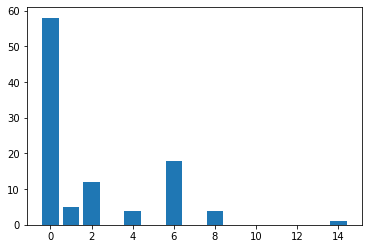

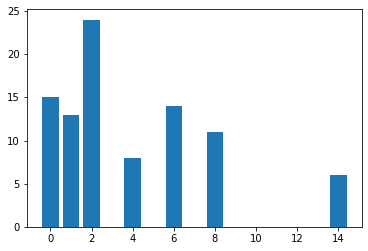

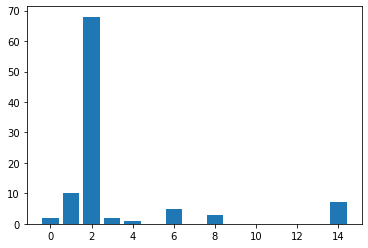

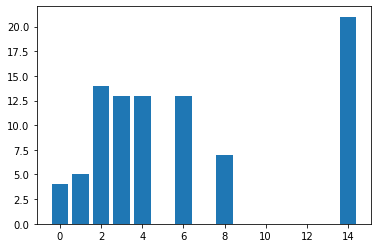

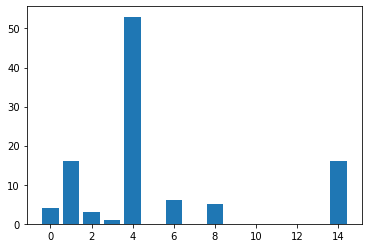

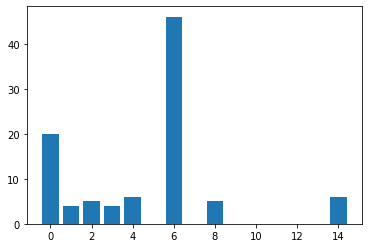

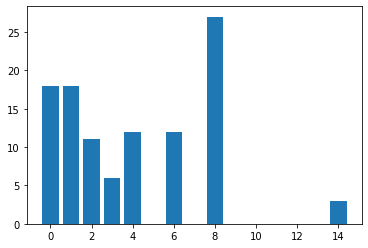

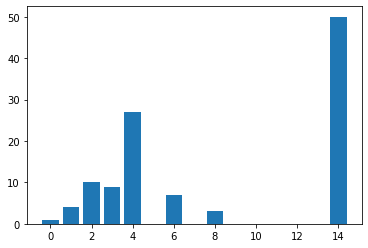

In [26]:
import matplotlib.pyplot as plt

for i in np.unique(test_data_label):
    true_ind = np.where(test_data_label == i)[0]
    pred_genres = labels[true_ind]
    unique, counts = np.unique(pred_genres, return_counts=True)
   
    plt.figure()
    plt.bar(unique, counts)



In [101]:
genre_df.head(20)

,index,genre_id,title
0,20,21,Hip-Hop
1,9,10,Pop
2,11,12,Rock
3,31,38,Experimental
4,16,17,Folk
5,3,4,Jazz
6,14,15,Electronic
7,19,20,Spoken
8,1,2,International
9,13,14,Soul-RnB


In [150]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels= 1, kernel_size = 3, stride = 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 3, stride = 1)
#         self.conv3 = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size =2, stride = 1)
        self.ReLU = nn.ReLU()
#         self.fc1 = nn.Linear(1869, 32)
#         self.fc2 = nn.Linear(928, 256)
        self.fc3 = nn.Linear(1869, 16)
        self.softmax = nn.Softmax(dim = 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x[:,None, :, :]
        x = self.ReLU(self.conv1(x))
        x = self.maxpool(x)
        x = self.ReLU(self.conv2(x))
        x = self.maxpool(x)
#         x = self.ReLU(self.conv3(x))
#         x = self.maxpool(x)
#         x = self.ReLU(self.conv3(x))
#         x = self.maxpool(x)
        x = self.flatten(x) 
#         print(x.shape)
#         print(x.shape)
#         x = self.ReLU(self.fc1(x))
#         x = self.ReLU(self.fc1(x))
#         x = self.ReLU(self.fc2(x))
        x = self.softmax(self.fc3(x))
        
        return x

def evaluate(model, validation_loader, criterion):
    
    model.eval()
    
    val_loss = 0
    val_acc = 0
    
    for inputs, labels in validation_loader:
        outputs = model(inputs)
        val_loss += criterion(outputs, labels)
        _, true_labels = torch.max(labels, dim = 1)
        
        _, pred_labels = torch.max(outputs, dim = 1)
                
        val_acc += torch.tensor(torch.sum(pred_labels == true_labels).item()/len(pred_labels))
    
    val_loss = val_loss/len(validation_loader)
    val_acc = val_acc/len(validation_loader)
        
    return val_loss.detach().item(), val_acc.item()
        
        

def train_NN(model, train_loader, validation_loader, learning_rate:float, epochs:int=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        loss = 0
        for inputs, labels in train_loader:

            optimizer.zero_grad()
            
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)

            train_loss.backward()

            optimizer.step()

            loss += train_loss.item()

        loss = loss/len(train_loader)
        
        val_loss, val_acc = evaluate(model, validation_loader, criterion)

        print("epoch: {}/{}, train loss = {:.6f}, val loss = {:.6f}, val acc = {:.6f}".format(epoch+1, epochs, loss, val_loss, val_acc))
        
        if (epoch+1)%10 == 0:
            torch.save(model.state_dict(), 'mfcc_model_2')


            
    return None



In [145]:
# print(train_data.shape)
# train_data_tensor = torch.tensor(train_data)
# print(train_data_tensor.shape)
model = NN()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = 10, shuffle = False)
train_NN(model, train_loader, validation_loader, learning_rate = 1e-3, epochs = 100)

In [89]:
criterion = torch.nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(validation_data, batch_size = 1, shuffle = False)
loss, acc = evaluate(model, test_loader, criterion)
print(loss, acc)

2.6234893356760343 0.24722221493721008


In [151]:
# torch.save(model.state_dict(), 'mfcc_model_2')
fin_model = NN()
fin_model.load_state_dict(torch.load('mfcc_model'))
# # model.eval()

<All keys matched successfully>

In [ ]:
#mfcc model had 2 conv with 1 in 1 out kernel size 3 and 1 linear
#mfcc model 2 2 conv 115 112 2 linear 32, 16

In [96]:
row = file_path_df['file_path']

In [158]:
import librosa
i = 10

filename = 'data/fma_small/' + row[i]

try:
    y, sr = librosa.load(filename, sr=None, mono=True)
except (RuntimeError, audioread.NoBackendError):
    print('Failed to load ', filename)

song_id = row[i].rsplit('/')[1].rsplit('.')[0].lstrip('0')

    
mel = librosa.feature.mfcc(y=y)
m = torch.nn.AdaptiveAvgPool1d(2500)
mel = m(torch.from_numpy(mel))
mel = (mel - torch.min(mel)) / (torch.max(mel) - torch.min(mel))

genre_text = track_df[track_df['track_id'] == int(song_id)]['track_genre_top']

print('true:', genre_text)

true: 68    Folk
Name: track_genre_top, dtype: object


In [159]:
output = fin_model(mel[None, :,:])
pred_genre = torch.argmax(output, dim = 1).item()
print('predicted:', genre_df.iloc[0]['title'])

predicted: Hip-Hop


In [160]:
for i in range(100):
    filename = 'data/fma_small/' + row[i]

    try:
        y, sr = librosa.load(filename, sr=None, mono=True)
    except (RuntimeError, audioread.NoBackendError):
        print('Failed to load ', filename)

    song_id = row[i].rsplit('/')[1].rsplit('.')[0].lstrip('0')


    mel = librosa.feature.mfcc(y=y)
    m = torch.nn.AdaptiveAvgPool1d(2500)
    mel = m(torch.from_numpy(mel))
    mel = (mel - torch.min(mel)) / (torch.max(mel) - torch.min(mel))

    genre_text = track_df[track_df['track_id'] == int(song_id)]['track_genre_top']

#     print('true:', genre_text)
    output = fin_model(mel[None, :,:])
    pred_genre = torch.argmax(output, dim = 1).item()
    print('predicted:', genre_df.iloc[0]['title'])

predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: Hip-Hop
predicted: H